## Tutorial 07 - Non linear Elliptic problem
**_Keywords: DEIM, POD-Galerkin_**

### 1. Introduction

In this tutorial, we consider a non linear elliptic problem in a two-dimensional spatial domain $\Omega=(0,1)^2$. We impose a homogeneous Dirichlet condition on the boundary $\partial\Omega$. The source term is characterized by the following expression
$$
g(\boldsymbol{x}; \boldsymbol{\mu}) = 100\sin(2\pi x_0)cos(2\pi x_1) \quad \forall \boldsymbol{x} = (x_0, x_1) \in \Omega.
$$

This problem is characterized by two parameters. The first parameter $\mu_0$ controls the strength of the sink term and the second parameter $\mu_1$ the strength of the nonlinearity. The range of the two parameters is the following:
$$
\mu_0,\mu_1\in[0.01,10.0]
$$
The parameter vector $\boldsymbol{\mu}$ is thus given by
$$
\boldsymbol{\mu} = (\mu_0,\mu_1)
$$
on the parameter domain
$$
\mathbb{P}=[0.01,10]^2.
$$


In order to obtain a faster approximation of the problem, we pursue a model reduction by means of a POD-Galerkin reduced order method. In order to preserve the affinity assumption the discrete empirical interpolation method will be used on the forcing term $g(\boldsymbol{x}; \boldsymbol{\mu})$.



### 2. Parametrized formulation

Let $u(\boldsymbol{\mu})$ be the solution in the domain $\Omega$.

The strong formulation of the parametrized problem is given by: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})$ such that

$$ -\nabla^2u(\boldsymbol{\mu})+\frac{\mu_0}{\mu_1}(\exp\{\mu_1u(\boldsymbol{\mu})\}-1)=g(\boldsymbol{x}; \boldsymbol{\mu})$$
<br>
    
The corresponding weak formulation reads: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)+c\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \{v\in H_1(\Omega) : v|_{\partial\Omega}=0\}
$$
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(u, v;\boldsymbol{\mu})=\int_{\Omega} \nabla u\cdot \nabla v \ d\boldsymbol{x},$$
* the parametrized bilinear form $c(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$c(u, v;\boldsymbol{\mu})=\mu_0\int_{\Omega} \frac{1}{\mu_1}\big(\exp\{\mu_1u\} - 1\big)v \ d\boldsymbol{x},$$
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(v; \boldsymbol{\mu})= \int_{\Omega}g(\boldsymbol{x}; \boldsymbol{\mu})v \ d\boldsymbol{x}.$$

The output of interest $s(\boldsymbol{\mu})$ is given by
$$s(\boldsymbol{\mu}) = \int_{\Omega} v \ d\boldsymbol{x}$$
is computed for each $\boldsymbol{\mu}$.

In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
import torch
import torch.nn as nn

import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import time

torch.manual_seed(0)
np.random.seed(0)

### 3. Affine Decomposition 

For this problem the affine decomposition is straightforward:
$$a(u,v;\boldsymbol{\mu})=\underbrace{1}_{\Theta^{a}_0(\boldsymbol{\mu})}\underbrace{\int_{\Omega}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_0(u,v)},$$
$$c(u,v;\boldsymbol{\mu})=\underbrace{\mu_0}_{\Theta^{c}_0(\boldsymbol{\mu})}\underbrace{\int_{\Omega}\frac{1}{\mu_1}\big(\exp\{\mu_1u\} - 1\big)v \ d\boldsymbol{x}}_{c_0(u,v)},$$
$$f(v; \boldsymbol{\mu}) = \underbrace{100}_{\Theta^{f}_0(\boldsymbol{\mu})} \underbrace{\int_{\Omega}\sin(2\pi x_0)cos(2\pi x_1)v \ d\boldsymbol{x}}_{f_0(v)}.$$
We will implement the numerical discretization of the problem in the class
```
class NonlinearElliptic(NonlinearEllipticProblem):
```
by specifying the coefficients $\Theta^{a}_*(\boldsymbol{\mu})$, $\Theta^{c}_*(\boldsymbol{\mu})$ and $\Theta^{f}_*(\boldsymbol{\mu})$ in the method
```
    def compute_theta(self, term):
```
and the bilinear forms $a_*(u, v)$, $c_*(u, v)$ and linear forms $f_*(v)$ in
```
    def assemble_operator(self, term):
```

In [2]:
@ExactParametrizedFunctions()
class NonlinearElliptic(NonlinearEllipticProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        NonlinearEllipticProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.du = TrialFunction(V)
        self.u = self._solution
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)
        # Store the forcing term expression
        self.f = Expression("sin(2*pi*x[0])*sin(2*pi*x[1])", element=self.V.ufl_element())
        #self.f = ParametrizedExpression(self, "sin(2*pi*mu[1]*x[0])*sin(2*pi*mu[1]*x[1])", element=self.V.ufl_element(), mu=(3., 0.5))
        # Customize nonlinear solver parameters
        self._nonlinear_solver_parameters.update({
            "linear_solver": "mumps",
            "maximum_iterations": 20,
            "report": True
        })

    # Return custom problem name
    def name(self):
        return "NonlinearEllipticExact"

    # Return theta multiplicative terms of the affine expansion of the problem.
    @compute_theta_for_derivatives
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = 1.
            return (theta_a0,)
        elif term == "c":
            theta_c0 = mu[0]
            return (theta_c0,)
        elif term == "f":
            theta_f0 = 100.
            return (theta_f0,)
        elif term == "s":
            theta_s0 = 1.0
            return (theta_s0,)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    @assemble_operator_for_derivatives
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            du = self.du
            a0 = inner(grad(du), grad(v)) * dx
            return (a0,)
        elif term == "c":
            u = self.u
            mu = self.mu
            c0 = (exp(mu[1] * u) - 1) / mu[1] * v * dx
            return (c0,)
        elif term == "f":
            f = self.f
            f0 = f * v * dx
            return (f0,)
        elif term == "s":
            s0 = v * dx
            return (s0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant(0.0), self.boundaries, 1)]
            return (bc0,)
        elif term == "inner_product":
            du = self.du
            x0 = inner(grad(du), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")


# Customize the resulting reduced problem
@CustomizeReducedProblemFor(NonlinearEllipticProblem)
def CustomizeReducedNonlinearElliptic(ReducedNonlinearElliptic_Base):
    class ReducedNonlinearElliptic(ReducedNonlinearElliptic_Base):
        def __init__(self, truth_problem, **kwargs):
            ReducedNonlinearElliptic_Base.__init__(self, truth_problem, **kwargs)
            self._nonlinear_solver_parameters.update({
                "report": True,
                "line_search": "wolfe"
            })

    return ReducedNonlinearElliptic

## 4. Main program

### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/square.xml")
subdomains = MeshFunction("size_t", mesh, "data/square_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/square_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the NonlinearElliptic class

In [5]:
problem = NonlinearElliptic(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(0.1, 10.0), (0.1, 10.0)]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a POD-Galerkin method

In [6]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(8)#20)
reduction_method.set_tolerance(0)#1e-8)

### 4.5. Perform the offline phase

#### 4.5.1 Fit Reduction Method

In [7]:
reduction_method.initialize_training_set(100)
reduced_problem = reduction_method.offline()

In [8]:
class Net(nn.Module):
    def __init__(self, in_size, out_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(in_size, 40)
        #self.fc2 = nn.Linear(60, 60)
        self.fc3 = nn.Linear(40, out_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = torch.tanh(x)
        #x = self.fc2(x)
        #x = torch.tanh(x)
        x = self.fc3(x)
        return x
    
class Net2(nn.Module):
    def __init__(self, in_size, out_size):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(in_size, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, out_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc2(x)
        x = torch.tanh(x)
        x = self.fc3(x)
        return x

In [9]:
# Step 1
# Get nonlinear_terms, parameters, N0
nonlinear_terms = np.zeros((len(reduction_method.training_set), len(reduction_method.training_set), reduced_problem.N))
params = np.array(reduction_method.training_set)
N0 = lambda sol, param_idx: 0 # N0 identically 0

solutions = []
Basis_Matrix = np.array([v.vector()[:] for v in reduced_problem.basis_functions])

for mu in reduction_method.training_set:
    problem.set_mu(mu)
    solution = problem.solve()
    solutions.append(np.array(problem._solution.vector()[:]))

for i, mu in enumerate(reduction_method.training_set):
    problem.set_mu(mu)
    operator_form = problem.assemble_operator('c')[0]
    theta = problem.compute_theta('c')
    
    for j, solution in enumerate(solutions):
        problem._solution.vector()[:] = solution
        nonlinear_terms[i, j] = (theta * Basis_Matrix @ np.array(assemble(operator_form)[:]).reshape(-1, 1)).reshape(-1)
        
solutions_ = []
for sol in solutions:
    F = Function(V)
    F.vector()[:] = sol
    solutions_.append(np.array(reduced_problem.project(F).vector()[:]))
solutions = solutions_

In [10]:
chosen_parameter_indices = []
fixed_mu_networks = []

# Step 2
# 2a. Set mu_1
errors = np.zeros(params.shape[0])
for i, mu_i in enumerate(params):
    # compute error
    s = 0
    for j, mu_j in enumerate(params):
        s += np.sum((nonlinear_terms[i, j] - N0(solutions[j], i))**2)
    errors[i] = s / params.shape[0]

mu_1_idx = np.argmax(errors)
mu_1 = params[mu_1_idx]
chosen_parameter_indices.append(mu_1_idx)
print("max error:", np.max(errors))
print("mu_1 index:", mu_1_idx)

# 2b. Train Network_{mu_1}(u) to approximate Nonlinearity(u; mu_1)
print("\nTraining network to approximate nonlinearity...")
Network_mu_1 = Net(reduced_problem.N, reduced_problem.N)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(Network_mu_1.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)

x_normalization = Normalization.MinMaxNormalization(input_normalization=True)
y_normalization = Normalization.MinMaxNormalization()

x_data = x_normalization(torch.tensor(np.array(solutions)).float())
y_data = y_normalization(torch.tensor(nonlinear_terms[mu_1_idx] / np.linalg.norm(nonlinear_terms[mu_1_idx])).float().T).T



for epoch in range(30000):
    optimizer.zero_grad()
    output = Network_mu_1(x_data)
    loss = criterion(output, y_data)
    if epoch % 100 == 0:
        print(epoch, loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()

Network_mu_1.eval()
fixed_mu_networks.append(Network_mu_1)

# 2c. Find theta_1_1(mu)
print("\nFinding theta...")
thetas = np.zeros((params.shape[0], 1))
for i, mu_i in enumerate(params):
    numerator = 0
    denominator = 0
    for j, mu_j in enumerate(params):
        net_u_mu = y_normalization(Network_mu_1(x_data[j].view(1, -1)).T, normalize=False).T.detach().numpy().reshape(-1)
        numerator += np.dot(nonlinear_terms[i, j], net_u_mu)
        denominator += np.dot(net_u_mu, net_u_mu)
        
    theta_1_1_i = numerator / denominator
    thetas[i] = theta_1_1_i
    print(thetas[i])

max error: 152382.4079670945
mu_1 index: 74

Training network to approximate nonlinearity...
0 0.6242950558662415
100 0.03480248153209686
200 0.014270410872995853
300 0.010278531350195408
400 0.008695569820702076
500 0.007538149133324623
600 0.006562786176800728
700 0.00572533905506134
800 0.005002230871468782
900 0.004364647436887026
1000 0.0037818970158696175
1100 0.003231752896681428
1200 0.002708193613216281
1300 0.0022216527722775936
1400 0.0017917152727022767
1500 0.0014358728658407927
1600 0.0011601739097386599
1700 0.0009571917471475899
1800 0.0008113357471302152
1900 0.0007059931522235274
2000 0.0006278006476350129
2100 0.0005675519350916147
2200 0.000519398192409426
2300 0.00047972609172575176
2400 0.00044628282194025815
2500 0.00041760946623981
2600 0.00039271515561267734
2700 0.0003708873991854489
2800 0.00035158879472874105
2900 0.00033439925755374134
3000 0.0003189792623743415
3100 0.0003050515952054411
3200 0.00029238415299914777
3300 0.00028078482137061656
3400 0.000270

29100 6.927559752512025e-07
29200 6.888355983392103e-07
29300 6.850876275166229e-07
29400 6.811603725509485e-07
29500 6.774072858206637e-07
29600 6.736323143741174e-07
29700 6.699943355670257e-07
29800 6.662783107458381e-07
29900 6.62654372263205e-07

Finding theta...
[210.23106525]
[53.04380728]
[88.4415651]
[861.47725577]
[23.84580296]
[60.86147794]
[1535.85391072]
[0.27560114]
[33.42780473]
[1234.49541004]
[798.89691638]
[320.96254471]
[24.8513629]
[489.52954638]
[16.44028118]
[176.44573139]
[49.07392684]
[4.61412386]
[98.77395757]
[266.55137064]
[13.54322966]
[2.00963417]
[171.38069111]
[0.97920888]
[6.90166057]
[21.52115053]
[3.73564241]
[1.19363817]
[6.54269199]
[4.4324528]
[0.6672633]
[3.13842814]
[4.54445839]
[3.01187626]
[3.05344947]
[46.20853292]
[141.27249856]
[1.83700447]
[1.23071619]
[1.27476942]
[10.10920526]
[22.80291476]
[6.16660351]
[1.89371864]
[1613.00413742]
[80.8893796]
[53.92146794]
[1.87571376]
[1.26977836]
[1.58051283]
[7.58704447]
[2814.88463942]
[29.06681797]


In [11]:
matrices = []
maximum_error = np.max(errors)
y_normalization_list = [y_normalization]
mean_errors = 1

mean_errors_list = []
mean_errors_list_all = []

#while np.mean(mean_errors) > 0.0005:
for iteration in range(7):
    # Step 3
    # 3a. Set mu_2
    N1 = lambda sol, param_idx: sum([
        thetas[param_idx][i] * y_normalization_list[i](
            net(x_normalization(torch.tensor(sol).float().view(1, -1))).T, normalize=False
        ).T.detach().numpy().reshape(-1)\
        for i, net in enumerate(fixed_mu_networks)
    ])
    
    

    errors = np.zeros(params.shape[0])
    for i, mu_i in enumerate(params):
        # compute error
        s = 0
        for j, mu_j in enumerate(params):
            s += np.sum((nonlinear_terms[i, j] - N1(solutions[j], i))**2)
        errors[i] = s / params.shape[0]
        
    mean_errors = np.zeros(params.shape[0])
    for i, mu_i in enumerate(params):
        mean_errors[i] = np.linalg.norm(nonlinear_terms[i, i] - N1(solutions[i], i)) / np.linalg.norm(nonlinear_terms[i, i])
    
    mean_errors_all = np.zeros(params.shape[0])
    for i, mu_i in enumerate(params):
        for j, mu_j in enumerate(params):
            mean_errors_all[i] += np.linalg.norm(nonlinear_terms[i, j] - N1(solutions[j], i)) / np.linalg.norm(nonlinear_terms[i, j])
        mean_errors_all[i] /= params.shape[0]
        
    print("max error:", np.max(errors))
    errors[np.array(chosen_parameter_indices)] = -1 # don't choose already chosen parameters again
    mu_2_idx = np.argmax(errors)
    mu_2 = params[mu_1_idx]
    chosen_parameter_indices.append(mu_2_idx)
    
    maximum_error = np.max(errors)
    print("mean error:", np.mean(mean_errors))
    mean_errors_list.append(np.mean(mean_errors))
    print("mean error all:", np.mean(mean_errors_all))
    mean_errors_list_all.append(np.mean(mean_errors_all))
    print("mu_2 index:", mu_2_idx)

    # 3b. Train Network_{mu_2}(u) to approximate Nonlinearity(u; mu_2)
    print("\nTraining network to approximate nonlinearity...")
    Network_mu_2 = Net(reduced_problem.N, reduced_problem.N)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(Network_mu_2.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)
    
    
    # need to do Gram-Schmidt on this matrix
    y_data = nonlinear_terms[mu_2_idx]
    
    for net in fixed_mu_networks:
        # form matrix of evaluations for this network
        previous_net_matrix = np.zeros((params.shape[0], nonlinear_terms.shape[2]))
        for i, mu_i in enumerate(params):
            previous_net_matrix[i] = y_normalization(net(x_data[i].view(1, -1)).T, normalize=False).T.detach().numpy().reshape(-1)
        
        # subtract out projection of y_data onto previous_net_matrix from y_data
        y_data -= np.sum(y_data * previous_net_matrix) / np.linalg.norm(previous_net_matrix) * previous_net_matrix
    
    y_data = torch.tensor(y_data / np.linalg.norm(y_data)).float()
    y_normalization = Normalization.MinMaxNormalization()
    y_data = y_normalization(y_data.T).T
    
    

    for epoch in range(30000):
        optimizer.zero_grad()
        output = Network_mu_2(x_data)
        loss = criterion(output, y_data)
        if epoch % 100 == 0:
            print(epoch, loss.item())
        loss.backward()
        optimizer.step()
        scheduler.step()

    Network_mu_2.eval()
    fixed_mu_networks.append(Network_mu_2)
    y_normalization_list.append(y_normalization)

    # 3c. Find theta_1_2(mu), theta_2_2(mu)
    print("\nFinding theta...")
    num_nets = len(fixed_mu_networks)
    thetas = np.zeros((params.shape[0], num_nets))
    for i, mu_i in enumerate(params):
        LHS_numerator = np.zeros((num_nets, num_nets))
        LHS_denominator = np.zeros((num_nets, num_nets))
        RHS_numerator = np.zeros((num_nets, 1))
        RHS_denominator = np.zeros((num_nets, 1))

        for j, mu_j in enumerate(params):
            nets_u_mu = [y_normalization_list[i_net](net(x_data[j].view(1, -1)).T, normalize=False).T.detach().numpy().reshape(-1) for i_net, net in enumerate(fixed_mu_networks)]

            for k1 in range(num_nets):
                RHS_numerator[k1] += np.dot(nonlinear_terms[i, j], nets_u_mu[k1])
                RHS_denominator[k1] += np.dot(nets_u_mu[k1], nets_u_mu[k1])
                for k2 in range(num_nets):
                    
                    LHS_numerator[k1, k2] += np.dot(nets_u_mu[k1], nets_u_mu[k2])
                    LHS_denominator[k1, k2] += np.dot(nets_u_mu[k1], nets_u_mu[k1])



        LHS = LHS_numerator / LHS_denominator
        RHS = RHS_numerator / RHS_denominator
        matrices.append(LHS)
        thetas[i] = np.linalg.solve(LHS, RHS).reshape(-1)
        #print(thetas[i])

max error: 146.36978410950547
mean error: 0.6604943667429336
mean error all: 0.6377859988703688
mu_2 index: 82

Training network to approximate nonlinearity...
0 0.6586200594902039
100 0.07487227022647858
200 0.03838849440217018
300 0.025612778961658478
400 0.021287748590111732
500 0.01836969330906868
600 0.01563423126935959
700 0.012714305892586708
800 0.009505297057330608
900 0.006529889535158873
1000 0.004430945962667465
1100 0.003188231261447072
1200 0.0024546643253415823
1300 0.001991936471313238
1400 0.0016832472756505013
1500 0.0014694544952362776
1600 0.0013163237599655986
1700 0.0012025305768474936
1800 0.001114756683818996
1900 0.001044749515131116
2000 0.000987327191978693
2100 0.0009391132625751197
2200 0.0008978051482699811
2300 0.0008617640123702586
2400 0.0008297878666780889
2500 0.0008009799639694393
2600 0.0007746631163172424
2700 0.0007503264350816607
2800 0.0007275768439285457
2900 0.0007061131182126701
3000 0.0006856960244476795
3100 0.0006661345832981169
3200 0.000

29000 5.26736721440102e-06
29100 5.212858468439663e-06
29200 5.189080638956511e-06
29300 5.165630227565998e-06
29400 5.143146154296119e-06
29500 5.119047727930592e-06
29600 5.09582332597347e-06
29700 5.073095508123515e-06
29800 5.050333129474893e-06
29900 5.027748557040468e-06

Finding theta...
max error: 0.6218764548711353
mean error: 0.2812045058509791
mean error all: 0.34562643159453965
mu_2 index: 36

Training network to approximate nonlinearity...
0 0.801239550113678
100 0.05150529369711876
200 0.019416479393839836
300 0.009208738803863525
400 0.006099633406847715
500 0.00503834243863821
600 0.0044128685258328915
700 0.003907748498022556
800 0.0034613427706062794
900 0.0030578267760574818
1000 0.00269255880266428
1100 0.0023651435039937496
1200 0.002075759693980217
1300 0.001822581049054861
1400 0.0016015090513974428
1500 0.0014078026870265603
1600 0.001237626769579947
1700 0.0010884227231144905
1800 0.0009584250510670245
1900 0.0008460559183731675
2000 0.0007495891186408699
2100 

27900 4.374035711407487e-07
28000 4.356868998911523e-07
28100 4.3396477167334524e-07
28200 4.3232458324382605e-07
28300 4.3058471987933444e-07
28400 4.289703667836875e-07
28500 4.2730920313260867e-07
28600 4.2572600023049745e-07
28700 4.2414094991727325e-07
28800 4.233494905747648e-07
28900 4.21061855604421e-07
29000 4.204331958135299e-07
29100 4.180297423772572e-07
29200 4.1655988525235443e-07
29300 4.15082325844196e-07
29400 4.150121810653218e-07
29500 4.1220701518795977e-07
29600 4.120082053304941e-07
29700 4.0940997791949485e-07
29800 4.0802348166835145e-07
29900 4.066702956606605e-07

Finding theta...
max error: 0.5481746508301729
mean error: 0.2598455132348837
mean error all: 0.3184026527608861
mu_2 index: 61

Training network to approximate nonlinearity...
0 0.7448909282684326
100 0.07701390236616135
200 0.04243053123354912
300 0.0305677130818367
400 0.025421762838959694
500 0.021999690681695938
600 0.018621649593114853
700 0.01492184679955244
800 0.011137478053569794
900 0.0078

26600 1.4523097888741177e-05
26700 1.4424377695831936e-05
26800 1.4326369637274183e-05
26900 1.4227951396605931e-05
27000 1.4131377611192875e-05
27100 1.4033890693099238e-05
27200 1.3937938092567492e-05
27300 1.384093047818169e-05
27400 1.3746609511144925e-05
27500 1.3651056178787258e-05
27600 1.3557074453274254e-05
27700 1.3462570677802432e-05
27800 1.3369111911742948e-05
27900 1.327535392192658e-05
28000 1.3183274859329686e-05
28100 1.3090868378640153e-05
28200 1.2999244063394144e-05
28300 1.2906884876429103e-05
28400 1.2818416507798247e-05
28500 1.2729434274660889e-05
28600 1.264250840904424e-05
28700 1.255002189282095e-05
28800 1.2461337973945774e-05
28900 1.2373966455925256e-05
29000 1.2287222489248961e-05
29100 1.2200949640828185e-05
29200 1.2115121535316575e-05
29300 1.2030493962811306e-05
29400 1.1944752259296365e-05
29500 1.1861017810588237e-05
29600 1.1777064173656981e-05
29700 1.1693581654981244e-05
29800 1.1611114132392686e-05
29900 1.152884760813322e-05

Finding theta...
m

25300 1.9543613234418444e-06
25400 1.944653831742471e-06
25500 1.935178943313076e-06
25600 1.925826609294745e-06
25700 1.9165499907103367e-06
25800 1.9074161627941066e-06
25900 1.8994884385392652e-06
26000 1.907397290779045e-06
26100 1.8809821540344274e-06
26200 1.872968596217106e-06
26300 1.8643213479663245e-06
26400 1.877394652183284e-06
26500 1.8484013253328158e-06
26600 1.8399842929284205e-06
26700 1.8322075447940733e-06
26800 1.8245281125928159e-06
26900 1.816851295188826e-06
27000 1.8176436924477457e-06
27100 1.8149928564525908e-06
27200 1.7946526895684656e-06
27300 1.7875950106827077e-06
27400 1.78043103460368e-06
27500 1.7905558706843294e-06
27600 1.7698243937047664e-06
27700 1.7601321360416478e-06
27800 1.7535066945129074e-06
27900 1.7469408248871332e-06
28000 1.7405393464287044e-06
28100 1.7340790918751736e-06
28200 1.7277394590564654e-06
28300 1.7215935486092349e-06
28400 1.715812004476902e-06
28500 1.7095898101615603e-06
28600 1.7036785493473872e-06
28700 1.7019929146044888

24000 2.6497734779695747e-06
24100 2.640798811626155e-06
24200 2.614287041069474e-06
24300 2.606012003525393e-06
24400 2.579897682153387e-06
24500 2.5850074507616227e-06
24600 2.54663950727263e-06
24700 2.534653958718991e-06
24800 2.5141803234873805e-06
24900 2.526369144106866e-06
25000 2.4826354092510883e-06
25100 2.467060994604253e-06
25200 2.4519365524611203e-06
25300 2.462900965838344e-06
25400 2.422388661216246e-06
25500 2.407814008620335e-06
25600 2.3934101136546815e-06
25700 2.3790971681592055e-06
25800 2.3651766696275445e-06
25900 2.351401690248167e-06
26000 2.338187414352433e-06
26100 2.324263959962991e-06
26200 2.310908712388482e-06
26300 2.297858827660093e-06
26400 2.2862402602186194e-06
26500 2.2719113985658623e-06
26600 2.2592626010009553e-06
26700 2.2466497284767684e-06
26800 2.234331532235956e-06
26900 2.2220715436560567e-06
27000 2.2100714431871893e-06
27100 2.198310539824888e-06
27200 2.1863579604541883e-06
27300 2.1746998299931874e-06
27400 2.163242925234954e-06
27500

22800 4.579631877277279e-06
22900 4.575980256049661e-06
23000 4.550058747554431e-06
23100 4.535542302619433e-06
23200 4.5227952796267346e-06
23300 4.506821824179497e-06
23400 4.492874268180458e-06
23500 4.483941665966995e-06
23600 4.4652592805505265e-06
23700 4.451930635696044e-06
23800 4.4380349208950065e-06
23900 4.424905000632862e-06
24000 4.411364898260217e-06
24100 4.398555574880447e-06
24200 4.385578904475551e-06
24300 4.372608600533567e-06
24400 4.359915692475624e-06
24500 4.3584409468167e-06
24600 4.334880031819921e-06
24700 4.322516815591371e-06
24800 4.31024591307505e-06
24900 4.304496087570442e-06
25000 4.285946488380432e-06
25100 4.274607817933429e-06
25200 4.262109996489016e-06
25300 4.250457095622551e-06
25400 4.238801011524629e-06
25500 4.2272549762856215e-06
25600 4.2161000237683766e-06
25700 4.204281594866188e-06
25800 4.193364020466106e-06
25900 4.181908934697276e-06
26000 4.1754065023269504e-06
26100 4.160368007433135e-06
26200 4.149667347519426e-06
26300 4.140150849

21500 1.2823084034607746e-06
21600 1.2773714388458757e-06
21700 1.2720483937300742e-06
21800 1.2748848803312285e-06
21900 1.2620128018170362e-06
22000 1.2588400295499014e-06
22100 1.2522665429059998e-06
22200 1.2474941968321218e-06
22300 1.242731968886801e-06
22400 1.2380099860820337e-06
22500 1.2334497796473443e-06
22600 1.2288828656892292e-06
22700 1.2246342748767347e-06
22800 1.2198617014291813e-06
22900 1.216192117681203e-06
23000 1.2110423313060892e-06
23100 1.2068035175616387e-06
23200 1.2024697753076907e-06
23300 1.2004071550109074e-06
23400 1.1940996955672745e-06
23500 1.204743512062123e-06
23600 1.1858853667945368e-06
23700 1.1842884077850613e-06
23800 1.1777570989579544e-06
23900 1.173885380012507e-06
24000 1.1698630260070786e-06
24100 1.1663747727652662e-06
24200 1.1621498288150178e-06
24300 1.158365307674103e-06
24400 1.1560557595657883e-06
24500 1.1507779618114e-06
24600 1.1471570360299665e-06
24700 1.1433778581704246e-06
24800 1.1403648159102886e-06
24900 1.13608552965160

In [ ]:
# Final step: train interpolation for theta

theta_net = Net2(params.shape[1], thetas.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(theta_net.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)

x_data = torch.tensor(params).float()
y_data = torch.tensor(thetas).float()
theta_normalization = Normalization.IdentityNormalization()
y_data = theta_normalization(y_data.T).T
#x_test = torch.tensor(params_test).float()
#y_test = torch.tensor(thetas_test).float()


theta_net.train()

for epoch in range(20000):
    optimizer.zero_grad()
    output = theta_net(x_data)
    loss = criterion(output, y_data)
    if epoch % 1 == 0:
        with torch.no_grad():
            #output_test = theta_net(x_test)
            #loss_test = criterion(output_test, y_test)
            print(epoch, loss.item())#, loss_test.item())
    loss.backward()
    optimizer.step()
    scheduler.step()

optimizer = torch.optim.Adam(theta_net.parameters(), lr=0.0008)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)
    
for epoch in range(20000):
    optimizer.zero_grad()
    output = theta_net(x_data)
    loss = criterion(output, y_data)
    if epoch % 1 == 0:
        with torch.no_grad():
            #output_test = theta_net(x_test)
            #loss_test = criterion(output_test, y_test)
            print(epoch, loss.item())#, loss_test.item())
    loss.backward()
    optimizer.step()
    scheduler.step()

theta_net.eval()

In [12]:
def NonlinearityApprox(u, mu):
    #thetas_ = theta_normalization(theta_net(torch.tensor(mu).float().view(1, -1)).detach().T, normalize=False).T.numpy().reshape(-1, 1)
    thetas_ = interpolate.griddata(params, thetas, mu, method='cubic').reshape(-1, 1)
    if True in np.isnan(thetas_):
        thetas_ = interpolate.griddata(params, thetas, mu, method='nearest').reshape(-1, 1)
    net_evals = np.array([y_normalization_list[i](net(x_normalization(torch.tensor(u).float().view(1, -1))).T, normalize=False).T.detach().numpy().reshape(-1) for i, net in enumerate(fixed_mu_networks)])
    return np.sum(thetas_ * net_evals, axis=0)

def NonlinearityApprox2(u, mu):
    #thetas_ = theta_normalization(theta_net(torch.tensor(mu).float().view(1, -1)).T, normalize=False).T.view(-1)
    thetas_ = interpolate.griddata(params, thetas, mu, method='cubic').reshape(-1)
    if True in np.isnan(thetas_):
        thetas_ = interpolate.griddata(params, thetas, mu, method='nearest').reshape(-1)
    s = 0
    for i, net in enumerate(fixed_mu_networks):
        s += thetas_[i] * y_normalization_list[i](net(x_normalization(u.view(1, -1))).T, normalize=False).T.view(-1)
    return s

In [ ]:
params_test = []
for x in np.linspace(2., 4., 10):
    for y in np.linspace(0.1, 1., 10):
        params_test.append([x, y])
params_test = np.array(params_test)

solutions_test = []
nonlinear_terms_test = np.zeros((params_test.shape[0], params_test.shape[0], reduced_problem.N))


for mu in params_test:
    problem.set_mu((mu[0], mu[1]))
    solution = problem.solve()
    solutions_test.append(np.array(problem._solution.vector()[:]))

for i, mu in enumerate(params_test):
    problem.set_mu((mu[0], mu[1]))
    operator_form = problem.assemble_operator('c')[0]
    theta = problem.compute_theta('c')
    
    for j, solution in enumerate(solutions_test):
        problem._solution.vector()[:] = solution
        nonlinear_terms_test[i, j] = (theta * Basis_Matrix @ np.array(assemble(operator_form)[:]).reshape(-1, 1)).reshape(-1)
        
solutions_ = []
for sol in solutions_test:
    F = Function(V)
    F.vector()[:] = sol
    solutions_.append(np.array(reduced_problem.project(F).vector()[:]))
solutions_test = solutions_

approximations_test = []
for i, p1 in enumerate(params_test):
    approximations_test.append([])
    for j, p2 in enumerate(params_test):
        approximations_test[-1].append(NonlinearityApprox(solutions_test[j], p1))
approximations_test = np.array(approximations_test)

errors = []
for i in range(nonlinear_terms_test.shape[0]):
    #errors.append(0)
    for j in range(nonlinear_terms_test.shape[1]):
        error = np.linalg.norm(nonlinear_terms_test[i, j] - approximations_test[i, j]) / np.linalg.norm(nonlinear_terms_test[i, j])
        errors.append(error)
    #errors[-1] /= nonlinear_terms_test.shape[0]

In [ ]:
for idx in range(nonlinear_terms.shape[0]):
    print(np.linalg.norm(NonlinearityApprox(solutions[idx], params[idx]) - nonlinear_terms[idx, idx]), np.linalg.norm(NonlinearityApprox(solutions[idx], params[idx]) - nonlinear_terms[idx, idx])/np.linalg.norm(nonlinear_terms[idx, idx]))
    #print(nonlinear_terms[idx, idx])
    #print(NonlinearityApprox(solutions[idx], params[idx]))
    #print("\n\n")
print("")
print(np.mean([np.linalg.norm(NonlinearityApprox(solutions[idx], params[idx]) - nonlinear_terms[idx, idx]) for idx in range(nonlinear_terms.shape[0])]))
print(np.mean([np.linalg.norm(NonlinearityApprox(solutions[idx], params[idx]) - nonlinear_terms[idx, idx])/np.linalg.norm(nonlinear_terms[idx, idx]) for idx in range(nonlinear_terms.shape[0])]))

In [ ]:
actual_errors = np.diagonal(np.array(errors).reshape((params_test.shape[0], params_test.shape[0])))
plt.scatter(params_test[:, 0], params_test[:, 1], c=np.diagonal(np.array(errors).reshape((params_test.shape[0], params_test.shape[0])))[:])
plt.colorbar()
#plt.scatter(params_test[:, 0], params_test[:, 1], c=errors)
#plt.colorbar()
print(np.median(np.diagonal(np.array(errors).reshape((params_test.shape[0], params_test.shape[0])))[:]))

In [13]:
from rbnics.backends.basic.wrapping.delayed_transpose import DelayedTranspose
from rbnics.backends.online import OnlineFunction, OnlineVector
from rbnics.backends.common.time_series import TimeSeries
from rbnics.backends.dolfin.parametrized_tensor_factory import ParametrizedTensorFactory
from rbnics.backends.dolfin.evaluate import evaluate

class Approx_PINN_Loss(Losses.RONN_Loss_Base):
    """
    PINN_Loss

    ronn: object of type RONN

    RETURNS: loss function loss_fn(parameters, reduced order coefficients)
    """
    def __init__(self, ronn, normalization=None, beta=1., mu=None):
        super(Approx_PINN_Loss, self).__init__(ronn, mu)
        self.operators = None
        self.proj_snapshots = None
        self.T0_idx = None
        self.normalization = normalization
        if self.normalization is None:
            self.normalization = IdentityNormalization()

        self.beta = beta

        # if time dependent, we need the neural net to compute time derivative
        self.time_dependent = False

    def name(self):
        return "Approx_PINN"

    def _compute_operators(self):
        self.operators_initialized = True

        #self.operators = self.ronn.get_operator_matrices(self.mu)
        self.operators = self.ronn.get_reduced_operator_matrices(self.mu)

        if not self.normalization.initialized:
            self.normalization(self.ronn.get_projected_snapshots())

    def set_mu(self, mu):
        self.mu = mu
        self.operators_initialized = False

    def __call__(self, **kwargs):
        pred = kwargs["prediction_no_snap"]
        if not self.operators_initialized:
            self._compute_operators()

        pred = self.normalization(pred.T, normalize=False).T

        ##### 1st equation in system #####
        res1 = 0.0

        # these two could be combined when both not None
        if 'f' in self.operators:
            res1 -= self.operators['f']
        if 'c' in self.operators:
            self.operators['c'] = torch.zeros_like(self.operators['c'])
            for i, mu in enumerate(kwargs["input_normalization"](kwargs["normalized_mu"], normalize=False)):                
                mu = np.array(mu)
                sol = pred[i].float()
                C = NonlinearityApprox2(sol, mu).view(-1, 1).double()#.detach()
                self.operators['c'][i] = C[None, :, :]

            res1 += self.operators['c']
        
        if 'a' in self.operators:
            res1 += torch.matmul(self.operators['a'], pred[:, :, None].double())

        loss1 = torch.mean(torch.sum(res1**2, dim=1)) if type(res1) is not float else res1
        if self.ronn.problem.dirichlet_bc_are_homogeneous:
            boundary_condition_loss = 0
        else:
            boundary_condition_loss = torch.mean((pred[:, 0] - 1.)**2)

        self.value = loss1 + self.beta*boundary_condition_loss

        return self.value

    def reinitialize(self, mu):
        normalization = self.normalization
        beta = self.beta
        return Approx_PINN_Loss(self.ronn, normalization, beta, mu)

In [14]:
torch.manual_seed(42)

input_normalization_pinn = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_pinn = Normalization.MinMaxNormalization()

pinn_net  = NN.RONN("Approx_PINN", problem, reduction_method, n_hidden=2, n_neurons=60)
pinn_loss = Approx_PINN_Loss(pinn_net, output_normalization_pinn)
data      = RONNData.RONNDataLoader(pinn_net, validation_proportion=0.2, 
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

pinn_trainer = Training.PINNTrainer(
    pinn_net, data, pinn_loss, optimizer, scheduler,
    input_normalization_pinn, num_epochs=10000, print_every=1
)

loaded, starting_epoch = IO.initialize_parameters(
    pinn_net, data, pinn_trainer, optimizer
)

In [15]:
pinn_trainer.train()

0:  |F(x)| = 0.615007; step 1
1:  |F(x)| = 0.0650331; step 1
2:  |F(x)| = 0.000847043; step 1
3:  |F(x)| = 1.45454e-07; step 1
scipy solver converged in 5 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 's' not implemented. Continuing without operator 's'...
0:  |F(x)| = 3.70614; step 0.313635
1:  |F(x)| = 2.36937; step 0.3432
2:  |F(x)| = 0.396391; step 1
3:  |F(x)| = 0.0251103; step 1
4:  |F(x)| = 0.000125399; step 1
5:  |F(x)| = 3.23655e-09; step 1
scipy solver converged in 7 iterations.
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 's' not implemented. Continuing without operator 's'...
43 176.0807279653296 	Loss(validation) = 36.153379733546544
44 104.44049653400688 	Loss(validation) = 90.38205081220194
45 150.66094128393084 	Loss(validation) = 64.13167937907025
46 132.04962021467185 	Loss(validation) = 12.489837902145533
47 89.9647318687754 	Loss(validation) = 16.220695258991633
48 121.03683513356536 	Loss(vali

169 76.8865545309222 	Loss(validation) = 17.171733207405303
170 76.83701275711769 	Loss(validation) = 17.190075972176004
171 76.78771540822329 	Loss(validation) = 17.19417236340428
172 76.73828877124497 	Loss(validation) = 17.1735620129724
173 76.68880626165696 	Loss(validation) = 17.144127254994032
174 76.63936801625613 	Loss(validation) = 17.130280590626498
175 76.59005388869807 	Loss(validation) = 17.14165340059252
176 76.54052008742715 	Loss(validation) = 17.165872999243213
177 76.49088913373214 	Loss(validation) = 17.180182651182804
178 76.44145071386912 	Loss(validation) = 17.174350277304114
179 76.39190148495638 	Loss(validation) = 17.15724929598077
180 76.34228171545267 	Loss(validation) = 17.1474589423918
181 76.29270206991804 	Loss(validation) = 17.154422035296637
182 76.2430704653918 	Loss(validation) = 17.17031384459244
183 76.19340312349658 	Loss(validation) = 17.179680295109254
184 76.14368005601708 	Loss(validation) = 17.173441539787444
185 76.09394574999544 	Loss(valida

305 69.64569552921313 	Loss(validation) = 17.86789580191036
306 69.58648458347179 	Loss(validation) = 17.85514790563411
307 69.52708160867924 	Loss(validation) = 17.84154153535845
308 69.46733276211678 	Loss(validation) = 17.828199667989583
309 69.40733690528698 	Loss(validation) = 17.813867067377764
310 69.34707750966427 	Loss(validation) = 17.79757957023279
311 69.28653183382679 	Loss(validation) = 17.780497834859
312 69.22556408904336 	Loss(validation) = 17.763539168296344
313 69.1643159428142 	Loss(validation) = 17.746096167095534
314 69.10268491042952 	Loss(validation) = 17.726803261947378
315 69.0405632290897 	Loss(validation) = 17.706538995086905
316 68.97812347606067 	Loss(validation) = 17.6854376560282
317 68.91539877540637 	Loss(validation) = 17.66429175996225
318 68.85209702390237 	Loss(validation) = 17.641875994393196
319 68.7882212853217 	Loss(validation) = 17.61853988310533
320 68.72392460347031 	Loss(validation) = 17.593395287620442
321 68.65917455961153 	Loss(validation

440 41.75002046878267 	Loss(validation) = 16.68344702950833
441 41.43015845999163 	Loss(validation) = 16.70764465844455
442 41.11794055024063 	Loss(validation) = 16.730119080368866
443 40.813383963787246 	Loss(validation) = 16.750654974045823
444 40.51653464319675 	Loss(validation) = 16.769470432435007
445 40.22732654769154 	Loss(validation) = 16.785806725496435
446 39.945807556456366 	Loss(validation) = 16.800451270484242
447 39.67187392489368 	Loss(validation) = 16.813549869891084
448 39.4053246392361 	Loss(validation) = 16.82461651776589
449 39.14626035047102 	Loss(validation) = 16.833586588519836
450 38.894313275219545 	Loss(validation) = 16.84053873410264
451 38.64949033082045 	Loss(validation) = 16.845822820724663
452 38.41143969163412 	Loss(validation) = 16.849402620992553
453 38.179970770066916 	Loss(validation) = 16.851058907838265
454 37.954975539574974 	Loss(validation) = 16.850633298167253
455 37.73622475944787 	Loss(validation) = 16.848504401806405
456 37.52328874968472 	L

575 27.055418123462108 	Loss(validation) = 16.779524660683766
576 27.015269492823563 	Loss(validation) = 16.78510837219344
577 26.975560287773554 	Loss(validation) = 16.790392710886216
578 26.936189875317258 	Loss(validation) = 16.795850157128175
579 26.897230192516417 	Loss(validation) = 16.801055736429714
580 26.858701686846054 	Loss(validation) = 16.80585110814961
581 26.820530351318787 	Loss(validation) = 16.810874107922167
582 26.78272058904925 	Loss(validation) = 16.81574986420989
583 26.74527066836297 	Loss(validation) = 16.820117647772115
584 26.7082049596198 	Loss(validation) = 16.82455222201525
585 26.671545911978274 	Loss(validation) = 16.828634363928057
586 26.63518485889609 	Loss(validation) = 16.832513550207135
587 26.599239146925754 	Loss(validation) = 16.836251967261354
588 26.563660176179347 	Loss(validation) = 16.839659467747197
589 26.52835786985682 	Loss(validation) = 16.842903377681985
590 26.493458690361706 	Loss(validation) = 16.845722837006967
591 26.45890910476

709 23.813882577222568 	Loss(validation) = 15.587756426395192
710 23.79875873247203 	Loss(validation) = 15.57988670232156
711 23.783694636436454 	Loss(validation) = 15.572085575271597
712 23.76872680155572 	Loss(validation) = 15.565094177810172
713 23.75386566808944 	Loss(validation) = 15.557822788465852
714 23.73910152287739 	Loss(validation) = 15.551540255356269
715 23.724381534030453 	Loss(validation) = 15.544997894966212
716 23.70975392805073 	Loss(validation) = 15.539359814706694
717 23.695222858224636 	Loss(validation) = 15.53362727925484
718 23.680773409846687 	Loss(validation) = 15.528773177969288
719 23.66642892506896 	Loss(validation) = 15.52366563775486
720 23.652124305944408 	Loss(validation) = 15.519481746016528
721 23.637920203398654 	Loss(validation) = 15.515398356113968
722 23.62380819911586 	Loss(validation) = 15.511762026089173
723 23.609808859902653 	Loss(validation) = 15.508604487876042
724 23.595862977844654 	Loss(validation) = 15.505514695259327
725 23.58200642506

843 22.377680197412978 	Loss(validation) = 17.522515026518214
844 22.3694395998504 	Loss(validation) = 17.56080235930235
845 22.36118324307748 	Loss(validation) = 17.583446702471186
846 22.352941686873585 	Loss(validation) = 17.617662547026868
847 22.344688649652106 	Loss(validation) = 17.646242349392274
848 22.3364929766634 	Loss(validation) = 17.674654172353094
849 22.328299418890303 	Loss(validation) = 17.709008886152006
850 22.3201345695988 	Loss(validation) = 17.733662946574682
851 22.311960680193476 	Loss(validation) = 17.77058929975556
852 22.303795154886302 	Loss(validation) = 17.79509803023116
853 22.295605459334073 	Loss(validation) = 17.83080076945216
854 22.28740840259947 	Loss(validation) = 17.85841318293212
855 22.27924055844742 	Loss(validation) = 17.89082771300228
856 22.271087477211644 	Loss(validation) = 17.922569329060643
857 22.262946129461216 	Loss(validation) = 17.951639717745376
858 22.254819905039028 	Loss(validation) = 17.986424864001712
859 22.24665161987717 	

977 21.252589467225395 	Loss(validation) = 22.72696447334979
978 21.236319072118278 	Loss(validation) = 22.68557665191276
979 21.222377448366412 	Loss(validation) = 22.763650693748186
980 21.211273284565557 	Loss(validation) = 22.832920226963203
981 21.202767267378828 	Loss(validation) = 22.815773728751456
982 21.195757862998658 	Loss(validation) = 22.96790008864271
983 21.189055151964727 	Loss(validation) = 22.890720036042193
984 21.181482362921233 	Loss(validation) = 23.076572883363344
985 21.172400098369348 	Loss(validation) = 22.9893913309852
986 21.1616803236294 	Loss(validation) = 23.15746797739387
987 21.149806665376552 	Loss(validation) = 23.107861904306514
988 21.137626389586824 	Loss(validation) = 23.22154524914249
989 21.125954475573003 	Loss(validation) = 23.238172103058492
990 21.11519887206374 	Loss(validation) = 23.28469825314599
991 21.105538362012474 	Loss(validation) = 23.367436251955052
992 21.096559835652677 	Loss(validation) = 23.359856102921963
993 21.087827481790

1110 19.70305650761468 	Loss(validation) = 29.85884021480815
1111 19.68880224447268 	Loss(validation) = 29.915744872967302
1112 19.674503100172842 	Loss(validation) = 29.972578019866734
1113 19.660142320316442 	Loss(validation) = 30.02900518394386
1114 19.645735328276835 	Loss(validation) = 30.085564701627295
1115 19.631293895549582 	Loss(validation) = 30.14229768071409
1116 19.61679175819837 	Loss(validation) = 30.198555398199566
1117 19.60226550072942 	Loss(validation) = 30.255253122667103
1118 19.587697022189033 	Loss(validation) = 30.311542756673987
1119 19.573057576574957 	Loss(validation) = 30.36771186649657
1120 19.558372132016483 	Loss(validation) = 30.424117445265903
1121 19.543622755995656 	Loss(validation) = 30.480142516729433
1122 19.528916690393388 	Loss(validation) = 30.536430853486717
1123 19.51409656101565 	Loss(validation) = 30.592505978674104
1124 19.499249782123243 	Loss(validation) = 30.64823350105467
1125 19.484301858225372 	Loss(validation) = 30.704421392142432
11

1243 17.510489238550043 	Loss(validation) = 36.24330218363022
1244 17.492878345178433 	Loss(validation) = 36.27743614033485
1245 17.475254647004157 	Loss(validation) = 36.31133175545985
1246 17.457614497257477 	Loss(validation) = 36.34499083811047
1247 17.439974363620525 	Loss(validation) = 36.37834679619187
1248 17.42233563756918 	Loss(validation) = 36.4116253447783
1249 17.404696454339124 	Loss(validation) = 36.444642208254734
1250 17.387053248801852 	Loss(validation) = 36.477349298032955
1251 17.369375690210273 	Loss(validation) = 36.509791594520195
1252 17.35168969607531 	Loss(validation) = 36.542088697857096
1253 17.33400645202391 	Loss(validation) = 36.574122235226625
1254 17.316343148243106 	Loss(validation) = 36.60599415718083
1255 17.298615877811937 	Loss(validation) = 36.63760674323861
1256 17.280922645811906 	Loss(validation) = 36.669088615615536
1257 17.263227688008747 	Loss(validation) = 36.70026829820901
1258 17.24551113569798 	Loss(validation) = 36.731281242920595
1259 1

KeyboardInterrupt: 

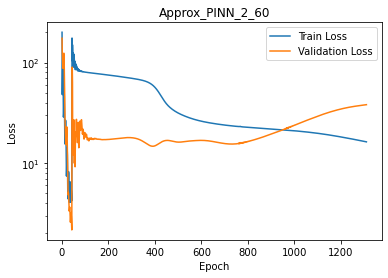

In [16]:
fig, ax = Training.plot_loss(pinn_trainer, pinn_net)

In [17]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

               nonlinear_terms: 625.1 KiB
                  Basis_Matrix: 74.3 KiB
                      solution:  9.4 KiB
                           sol:  9.4 KiB
                        thetas:  6.4 KiB
           previous_net_matrix:  6.4 KiB
                      matrices:  6.0 KiB
                          _i11:  4.7 KiB
                           _i2:  3.4 KiB
                          _i13:  3.0 KiB


#### 4.5.2 Train PINN

Given a training set $X_{PINN} = (\boldsymbol{\mu}^{(1)}, \dots, \boldsymbol{\mu}^{(n)})$ of parameters for the PDE, we train a Physics-Informed Neural Network (PINN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PINN}(X_{PINN}; W) = \frac1n \sum_{i=1}^n \left\|A(\boldsymbol{\mu^{(i)}}) \operatorname{N}_W(\boldsymbol{\mu}^{(i)}) - \boldsymbol{f}(\boldsymbol{\mu}^{(i)}) + \boldsymbol{c}(\boldsymbol{\mu}^{(i)})\right\|_2^2$$

over $W$, where for a given $\boldsymbol{\mu}$, $A(\boldsymbol{\mu})$ is the assembled matrix corresponding to the bilinear form $a$, $\boldsymbol{f}(\boldsymbol{\mu})$ is the assembled vector corresponding to the linear form $f$, and $\boldsymbol{c}(\boldsymbol{\mu})$ is a vector corresponding to the nonlinear form $c$.

In [ ]:
input_normalization_pinn = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_pinn = Normalization.MinMaxNormalization(input_normalization=False)

pinn_net  = NN.RONN("PINN", problem, reduction_method, n_hidden=2, n_neurons=40)
pinn_loss = Losses.PINN_Loss(pinn_net, output_normalization_pinn)
data      = RONNData.RONNDataLoader(pinn_net, validation_proportion=0.2, 
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)
scheduler = None

pinn_trainer = Training.PINNTrainer(
    pinn_net, data, pinn_loss, optimizer, scheduler,
    input_normalization_pinn, num_epochs=10000, print_every=1
)

loaded, starting_epoch = IO.initialize_parameters(
    pinn_net, data, pinn_trainer, optimizer
)

In [ ]:
start = time.time()
pinn_trainer.train()
end = time.time()
print(end - start)

In [ ]:
fig, ax = Training.plot_loss(pinn_trainer, pinn_net)

#### 4.5.3 Train PDNN

Given a training set $X_{PDNN} = ((\boldsymbol{\mu}^{(1)}, \operatorname{HF}(\boldsymbol{\mu}^{(1)})), \dots, (\boldsymbol{\mu}^{(n)}, \operatorname{HF}(\boldsymbol{\mu}^{(n)})))$ of parameter and high fidelity solution pairs for the PDE, we train a Projection-Driven Neural Network (PDNN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function
$$L_{PDNN}(X_{PDNN}; W) = \frac1n \sum_{i=1}^n \|\operatorname{N}_W(\boldsymbol{\mu}^{(i)}) - \tilde{\operatorname{HF}}(\boldsymbol{\mu}^{(i)})\|_2^2,$$
where for a given $\boldsymbol{\mu}$, $\tilde{\operatorname{HF}}(\boldsymbol{\mu})$ is the projection of $\operatorname{HF}(\boldsymbol{\mu})$ onto the reduced order solution space.

In [ ]:
input_normalization_pdnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pdnn = Normalization.StandardNormalization()

pdnn_net  = NN.RONN("PDNN", problem, reduction_method, n_hidden=2, n_neurons=40)
pdnn_loss = Losses.PDNN_Loss(pdnn_net, output_normalization_pdnn)
data      = RONNData.RONNDataLoader(pdnn_net, validation_proportion=0.2)
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)

pdnn_trainer = Training.PDNNTrainer(
    pdnn_net, data, pdnn_loss, optimizer,
    input_normalization_pdnn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pdnn_net, data, pdnn_trainer, optimizer
)

In [ ]:
pdnn_trainer.train()

In [ ]:
fig, ax = Training.plot_loss(pdnn_trainer, pdnn_net)

#### 4.5.4 Train PRNN

We train a Physics-Reinforced Neural Network (PRNN) $N_W(\boldsymbol{\mu})$ dependnent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PRNN}(X_{PINN}, X_{PDNN}; W) = L_{PINN}(X_{PINN}; W) + \omega L_{PDNN}(X_{PDNN}; W),$$

where $\omega$ is a scaling parameter which can be chosen freely.

In [ ]:
input_normalization_prnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_prnn = Normalization.StandardNormalization()

omega = 1.
prnn_net  = NN.RONN(f"PRNN_{omega}", problem, reduction_method, n_hidden=2, n_neurons=40)
prnn_loss = Losses.PRNN_Loss(prnn_net, output_normalization_prnn, omega=omega)
data      = RONNData.RONNDataLoader(prnn_net, validation_proportion=0.2,
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(prnn_net.parameters(), lr=0.001)

prnn_trainer = Training.PRNNTrainer(
    prnn_net, data, prnn_loss, optimizer,
    input_normalization_prnn, num_epochs=1000
)

loaded, starting_epoch = IO.initialize_parameters(
    prnn_net, data, prnn_trainer, optimizer
)

In [ ]:
prnn_trainer.train()

In [ ]:
fig, ax = Training.plot_loss(prnn_trainer, prnn_net, separate=True)

### 4.6. Perform an error analysis

#### 4.6.1 Reduction Method Error Analysis

In [ ]:
reduction_method.initialize_testing_set(100)
#reduction_method.error_analysis()

#### 4.6.2 PINN Error Analysis

In [ ]:
test_mu = torch.tensor(reduction_method.testing_set)

In [ ]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pinn_net, test_mu, input_normalization_pinn, output_normalization_pinn, relative=True
)

In [ ]:
ErrorAnalysis.plot_solution_difference(
    pinn_net, (5., 5.), input_normalization_pinn, output_normalization_pinn, colorbar=True
)

#### 4.6.3 PDNN Error Analysis

In [ ]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_mu, input_normalization_pdnn, output_normalization_pdnn, relative=False
)

In [ ]:
ErrorAnalysis.plot_solution_difference(
    pdnn_net, (5., 5.), input_normalization_pdnn, output_normalization_pdnn
)

#### 4.6.4 PRNN Error Analysis

In [ ]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    prnn_net, test_mu, input_normalization_prnn, output_normalization_prnn, relative=False
)

In [ ]:
ErrorAnalysis.plot_solution_difference(
    prnn_net, (5., 5.), input_normalization_prnn, output_normalization_prnn
)

#### 4.6.5 Neural Network Error Comparison

In [ ]:
nets = dict()
nets["pinn_net"] = pinn_net
nets["pdnn_net"] = pdnn_net
nets["prnn_net"] = prnn_net

input_normalizations = dict()
input_normalizations["pinn_net"] = input_normalization_pinn
input_normalizations["pdnn_net"] = input_normalization_pdnn
input_normalizations["prnn_net"] = input_normalization_prnn

output_normalizations = dict()
output_normalizations["pinn_net"] = output_normalization_pinn
output_normalizations["pdnn_net"] = output_normalization_pdnn
output_normalizations["prnn_net"] = output_normalization_prnn

_ = ErrorAnalysis.error_analysis_by_network(
    nets, test_mu, input_normalizations, output_normalizations, relative=False
)

### 4.7. Perform a speedup analysis

In [ ]:
reduction_method.speedup_analysis()